# Refactor Public Goods Game
- Update_contributions_function now run for one player since I plan to add different decision rules for different types of players

## Overall TODOS

In [214]:
# Added specified player type proportions (population wide / or within groups if I am staying with group_size == 4 num_membership == 2)
# Completed 

#TODO Implement improved player-types (altruist and freerider) for split endowment case (make them a little more responsive versus totally static and identical) 
# aka varying degrees of altruism : debating this one – for behavioral / lab results reasons 

#DID Add player types and improved decision rule(s) for shared endowment case 
# Started on. The current decison rule works. Want to improve it even more
# M-20 Improved on it even more. Added between-group comparison for SHARED endowment.

#TODO
# I now want to change the type of randomness used. Rather than a uniform distribution, maybe something with a tail, etc. 

#TODO Behavior Issue. Check current output. Currently, very drastic changes in the first round, but then almost no changes occur later on. This should be worked on.

#TODO Additional issue : I do not think my scale factor is not working properly

#DID Initialize contributions for SHARED endowment case with player types
# Completed

#DID Fix Simulate Game Function for Shared Endowment Case
# Completed

#DID Improve the way my csv file looks and make sure it works with the monte carlo simulation portion (I think I am only saving the final iterations data as it stands)
# Completed. It now saves data from all iterations of the Simulation. HOWEVER !!!

## Completed Switch from numpyarray for MOI ==> Pandas DF. to_csv, as well as naming the rows/columns will be of
# great importance for my capacity to use the data in the future 
# Did, but now I cannot open the CSV FILE PROPERLY

#TODO Once I do the above, I can make better graphs that show (1) average group level cooperation, (2) average player level coop, (3) average round level coop, etc.

#TODO design in a way to allow for specific comparissons between the nature of the endowment (SHARED == 0/1) with same parameter sets 

#TODO parameterize to explore the parameter space

#TODO implement power analysis by estimating effect size given the information that I am storing 

#TODO I would be interested in creating some visual component for displaying the change of cooperation of time given different parameter sets -- potentially with
# a scroller feature 

In [2]:
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt

In [5]:
# Set up Parameters
NUM_MEMBERSHIP = 2 # Number of groups each player interacts with
ENDOWMENT = 50 # The Endowment each player receives 
SHARED = 2 # 1 if the endowment is shared across groups | 0 if it is split
GROUP_SIZE = 4 # size of each group
R = 0.5 # Scale factor
NUM_ROUNDS = 10 # Number of rounds that players will participate in the public good game

## When NUM_MEMBERSHIP == 2
NUM_GROUPS = GROUP_SIZE * 2 # number of groups
NUM_PLAYERS = GROUP_SIZE ** 2 # Number of players in the system

# Player type initialize 
METHOD = "conditional" # can take on values 'random', 'conditional', 'altruists', and 'mixed'

# For Monte Carlo Simulation
SIMS = 10000


In [6]:
def initailize_contribtions_with_player_types(NUM_PLAYERS, NUM_MEMBERSHIP, ENDOWMENT, SHARED, player_type_matrix):
    initial_contributions = np.zeros([NUM_PLAYERS,NUM_MEMBERSHIP]) 
    if SHARED:
        for player in range(NUM_PLAYERS):
            player_type = player_type_matrix[player]
            if player_type == 1: 
                #initial_contribution_first_group = random.randint(0, ENDOWMENT)
                initial_contribution_first_group =  int(np.random.normal(ENDOWMENT / NUM_MEMBERSHIP, ENDOWMENT / 5 )) # Trying out NORMAL DIST 
                initial_contribution_first_group = min(ENDOWMENT, initial_contribution_first_group)
                initial_contribution_first_group = max(0, initial_contribution_first_group ) # With normal DIST make sure it is within my bounds of feasibility

                initial_contributions[player][0] = initial_contribution_first_group
                for member in range(1, NUM_MEMBERSHIP):
                    successive_initial_contributions = random.randint(0,ENDOWMENT - initial_contribution_first_group)
                    initial_contributions[player][member] = successive_initial_contributions
                    initial_contribution_first_group += successive_initial_contributions
            if player_type == 2: # if altruist : this more so resembles "fairness" not altruism 
                initial_contributions[player][:] = ENDOWMENT / NUM_MEMBERSHIP
    else:
        for player in range(NUM_PLAYERS):
            player_type = player_type_matrix[player]
            if player_type == 1: # if they are a conditional cooperator
                for group_member in range(NUM_MEMBERSHIP):
                    #initial_contributions[player][group_member] = random.randint(0,(ENDOWMENT / NUM_MEMBERSHIP))
                    initial_contributions[player][group_member] = int(np.random.normal(ENDOWMENT / NUM_MEMBERSHIP*2, ENDOWMENT / 5)) # Trying out NORMAL DIST 
                    initial_contributions[player][group_member] = min(ENDOWMENT, initial_contributions[player][group_member])
                    initial_contributions[player][group_member] = max(0, initial_contributions[player][group_member]) # when using normal DISt make sure within bounds
            if player_type == 2: # if they are an altruist
                initial_contributions[player][:] = ENDOWMENT / NUM_MEMBERSHIP
    return initial_contributions

In [7]:
def formed_groups_matrix(GROUP_SIZE, NUM_GROUPS):
  """
  Function to form groups in the form of a matrix in a NUM_PLAYERS x NUM_GROUPS
  sized matrix. Currently it is hard coded for NUM_PLAYERS = 16, NUM_GROUPS =8,
  and NUM_MEMBERSHIP = 2. I have drawn out on paper trends that the different 
  combinations results in, but I am unsure of how to append players in a reason-
  able about of time. Previously I was using a while loop, but ...
  """
  groups_matrix = np.zeros([NUM_PLAYERS, NUM_GROUPS])
  if NUM_MEMBERSHIP == 2 and GROUP_SIZE == 4:
    for i in range(4):
      groups_matrix[i][0] = 1
      groups_matrix[i][i+1] = 1
    for i in range(4,7):
      groups_matrix[i][1] = 1
      groups_matrix[i][i+1] = 1
    for i in range(7,10):
      groups_matrix[i][2] = 1
      groups_matrix[i][i-2] = 1
    for i in range(10,13):
      groups_matrix[i][3] = 1
      groups_matrix[i][i-5] = 1
    for i in range(13,16):
      groups_matrix[i][4] = 1
      groups_matrix[i][i-8] = 1
  return groups_matrix

In [8]:
def calculuate_scaled_public_good(contributions, groups_matrix, NUM_PLAYERS, R):
  """
  Function to sum up the contributions in a given group and then scale it by the
  scale factor. Since it matters which contribution goes to which group I keep
  track of a contribution_index variable
  """
  public_good_matrix = np.zeros(NUM_GROUPS)
  for player in range(NUM_PLAYERS): # NUM_PLAYER x NUM_GROUPS
    contribution_index = 0 
    for group in range(NUM_GROUPS):
      if contribution_index > (NUM_MEMBERSHIP - 1):
        break
      if groups_matrix[player][group] == 1 and contribution_index < NUM_MEMBERSHIP:
        public_good_matrix[group] += contributions[player][contribution_index]
        contribution_index +=1
  scaled_public_good = R * public_good_matrix
  return scaled_public_good

## Functions for Split Endowment

In [9]:
def calculate_payoff_split(contributions, group_matrix, ENDOWMENT, scaled_public_good):
  """
  Calculates the payoff when the groups are economically independent (split endowment)
  this case is easier so I implemented it first
  """
  payoffs_matrix = np.zeros([NUM_PLAYERS,NUM_GROUPS])
  for player in range(NUM_PLAYERS):
    contribution_index = 0 
    for group in range(NUM_GROUPS):
      if contribution_index > (NUM_MEMBERSHIP - 1):
        break
      if group_matrix[player][group] == 1:
        payoffs_matrix[player][group] = (ENDOWMENT / NUM_MEMBERSHIP) - contributions[player][contribution_index] + (scaled_public_good[group] / GROUP_SIZE)
        contribution_index += 1
  return payoffs_matrix

### Player-Type Specific Update Functions

In [10]:
def update_contributions_split_freeride(player, contributions, payoff_matrix, group_matrix, ENDOWMENT, NUM_MEMBERSHIP):
    """
    eventually this can just be simply: return 0,0 (once I change the initialize function to be player type based)
    """
    contribution_index = 0
    for group in range(NUM_GROUPS):
        if contribution_index >= NUM_MEMBERSHIP:
            break
        if group_matrix[player][group] == 1:
            contributions[player][group] == 0 
        contribution_index +=1
    return contributions

In [11]:
def update_contributions_split_conditional(player, contributions, payoff_matrix, group_matrix, ENDOWMENT, NUM_MEMBERSHIP):
    """
    calculates the changes in contributions for a player who is of type 'conditional cooperator'. This player type bases their decisions off
    of their payoff in the previous round to their endowment (what could of been their personal account)
    """
    contribution_index = 0
    for group in range(NUM_GROUPS):
        if contribution_index >= NUM_MEMBERSHIP:
            break
        if group_matrix[player][group] == 1:
            if payoff_matrix[player][group] > (ENDOWMENT / NUM_MEMBERSHIP):
                if contributions[player][contribution_index] < ( ENDOWMENT / NUM_MEMBERSHIP):
                    increase_contribution = random.randint(0, (ENDOWMENT / NUM_MEMBERSHIP) - contributions[player][contribution_index])
                    contributions[player][contribution_index] += increase_contribution
            else:
                if contributions[player][contribution_index] > 0:
                    decrease_contribution = random.randint(0, contributions[player][contribution_index])
                    contributions[player][contribution_index] -=  decrease_contribution
            contributions[player][contribution_index] = min((ENDOWMENT / NUM_MEMBERSHIP), contributions[player][contribution_index] )
            contribution_index += 1 
    return contributions

In [12]:
def update_contributions_split_altruist(player, contributions, payoff_matrix, group_matrix, ENDOWMENT, NUM_MEMBERSHIP):
    """
    updates the contributions for a player who is of type altruist in the split endowment regime. I might change this function to add some variance
    to the contributions of an altruist rather than having a static player, but we will see
    """
    contribution_index = 0
    for group in range(NUM_GROUPS):
        if contribution_index >= NUM_MEMBERSHIP: 
            break
        if group_matrix[player][group] == 1:
            contributions[player][group] == ENDOWMENT / NUM_MEMBERSHIP
        contribution_index +=1
    return contributions

In [13]:
update_contributions_split_dict = {0: update_contributions_split_freeride,
                                   1: update_contributions_split_conditional,
                                   2: update_contributions_split_altruist
                                   }

In [14]:
def initialize_player_types(NUM_PLAYERS, update_contributions_split_dict, METHOD):
    """
    initializes the player types based off of different global parameter specified mixes 
    """
    player_type_matrix = np.zeros([NUM_PLAYERS,1])
    if METHOD == "random":
        player_type_matrix = np.random.randint(len(update_contributions_split_dict), size=(NUM_PLAYERS,1))
    elif METHOD == "conditional":
        player_type_matrix = np.ones([NUM_PLAYERS,1])
    elif METHOD == "altruists":
        player_type_matrix.fill(2) 
    elif METHOD == "mixed": # 2ccs per group, 1 fr, 1 al
        player_type_matrix[0], player_type_matrix[3], player_type_matrix[6], player_type_matrix[8:12], player_type_matrix[13] = 1, 1, 1, 1, 1
        player_type_matrix[1], player_type_matrix[4], player_type_matrix[12],player_type_matrix[14] = 2, 2, 2, 2
    return player_type_matrix

In [15]:
def update_contributions_split(player_type_matrix, contributions, payoff_matrix, group_matrix, ENDOWMENT, NUM_MEMBERSHIP):
    """
    utilizes the 'update_contributions_split_dict' to update the contributions for all players based off their player types 
    """
    for player in range(NUM_PLAYERS):
        player_type = int(player_type_matrix[player])
        update_contributions_split_use = update_contributions_split_dict[player_type]
        contributions = update_contributions_split_use(player, contributions, payoff_matrix, group_matrix, ENDOWMENT, NUM_MEMBERSHIP)
    return contributions 

### Testing Above Functions

In [158]:
player_types_matrix = initialize_player_types(NUM_PLAYERS,update_contributions_split_dict, method = 'conditional')
player_types_matrix

array([[1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.]])

In [72]:
#player_types_matrix = np.ones([NUM_PLAYERS,1])
contributions_example = initailize_contribtions_with_player_types(NUM_PLAYERS, NUM_MEMBERSHIP, ENDOWMENT, SHARED, player_types_matrix)
groups_example = formed_groups_matrix(GROUP_SIZE, NUM_GROUPS)
scaled_good_example = calculuate_scaled_public_good(contributions_example, groups_example, NUM_PLAYERS, R)
payoff_split_example = calculate_payoff_split(contributions_example, groups_example, ENDOWMENT, scaled_good_example)

In [73]:
print(contributions_example)
updated_contributions = update_contributions_split(player_types_matrix, contributions_example, payoff_split_example, groups_example, ENDOWMENT, NUM_MEMBERSHIP)
print("New")
updated_contributions

[[17. 21.]
 [50.  0.]
 [ 4.  9.]
 [40.  2.]
 [ 3. 25.]
 [19. 24.]
 [43.  5.]
 [18.  3.]
 [27. 23.]
 [ 1. 19.]
 [35. 14.]
 [38.  0.]
 [10. 34.]
 [22. 26.]
 [ 8. 24.]
 [29. 12.]]
New


array([[11.,  0.],
       [25.,  3.],
       [20., 14.],
       [25.,  8.],
       [23., 23.],
       [ 7., 16.],
       [25., 20.],
       [ 5., 20.],
       [25.,  5.],
       [ 2.,  2.],
       [25., 12.],
       [25.,  4.],
       [10.,  9.],
       [ 9., 15.],
       [ 8.,  7.],
       [24.,  4.]])

In [272]:
def update_contributions_split_conditional_test(contributions, payoff_matrix, group_matrix, ENDOWMENT, NUM_MEMBERSHIP):
    for player in range(NUM_PLAYERS):
        contribution_index = 0
        for group in range(NUM_GROUPS):
            if contribution_index >= NUM_MEMBERSHIP:
                break
            if group_matrix[player][group] == 1:
                if payoff_matrix[player][group] > (ENDOWMENT / NUM_MEMBERSHIP):
                    if contributions[player][contribution_index] < ( ENDOWMENT / NUM_MEMBERSHIP):
                        increase_contribution = random.randint(0, (ENDOWMENT / NUM_MEMBERSHIP) - contributions[player][contribution_index])
                        contributions[player][contribution_index] += increase_contribution
                else:
                    if contributions[player][contribution_index] > 0:
                        decrease_contribution = random.randint(0, contributions[player][contribution_index])
                        contributions[player][contribution_index] -=  decrease_contribution
                contributions[player][contribution_index] = min((ENDOWMENT / NUM_MEMBERSHIP), contributions[player][contribution_index] )
                contribution_index += 1 
    return contributions

## Functions when endowment is shared 

In [16]:
def calculate_payoff_shared(contributions, group_matrix, ENDOWMENT, scaled_public_good):
  """
  How to calculate the payoff for an indiivdal contributing to their groups
  The endowment is removed since it would be double counted
  """
  payoffs_matrix = np.zeros([NUM_PLAYERS,NUM_GROUPS])
  for player in range(NUM_PLAYERS):
    contribution_index = 0 
    for group in range(NUM_GROUPS):
      if contribution_index > (NUM_MEMBERSHIP - 1):
        break
      if group_matrix[player][group] == 1:
        payoffs_matrix[player][group] = - contributions[player][contribution_index] + (scaled_public_good[group] / GROUP_SIZE) 
        contribution_index += 1
  return payoffs_matrix
  # removed endowment for now since it is a little confusing with the endowment in both groups since it would double count 

In [17]:
def update_contributions_shared_conditional(player, contributions, payoff_matrix, group_matrix, ENDOWMENT, NUM_MEMBERSHIP):
    """
    function to update the contributions under the shared endowment regime for a player who is a conditional cooperator. 
    Conditional cooperators compare their within-group analysis (their payoff based on their contribution) and features
    a between-group analysis (their payoff between/among their groups)
    """
    contribution_index = 0
    in_group = []
    for group in range(NUM_GROUPS): # within-group analysis of gains/losses
        if contribution_index > NUM_MEMBERSHIP - 1:
            break
        if group_matrix[player][group] == 1:
            in_group.append(group)
            if payoff_matrix[player][group] >= 0: # checks if the player gained from cooperation
                current_players_total_contributions = contributions[player].sum()
                if current_players_total_contributions < ENDOWMENT:
                    increase_contribution = random.randint(0, ENDOWMENT - current_players_total_contributions)
                    contributions[player][contribution_index] += increase_contribution
            else: # if player lost from cooperation in a group
                if contributions[player][contribution_index] > 0: 
                    decrease_contribution = random.randint(0, contributions[player][contribution_index])
                    contributions[player][contribution_index] -= decrease_contribution
            contributions[player][contribution_index] = min(ENDOWMENT, contributions[player][contribution_index])
            contribution_index += 1
    for member in range(NUM_MEMBERSHIP - 1): # check between-group analysis of comparative gains/losses
        if contributions[player][member] > 0 and contributions[player][member + 1] > 0:
            difference = int(abs(contributions[player][member] - contributions[player][member + 1]))
            transfer = random.randint(0, difference)
            if payoff_matrix[player][in_group[member]] > payoff_matrix[player][in_group[member + 1]] :
                contributions[player][member] += transfer
                contributions[player][member + 1] -= transfer
            else:   
                contributions[player][member] -= transfer
                contributions[player][member + 1] += transfer
    return contributions

In [18]:
def update_contributions_shared_freeride(player, contributions, payoff_matrix, group_matrix, ENDOWMENT, NUM_MEMBERSHIP):
    """
    updates contribution in the shared endowment for a player who is a freerider. This player type is static at 0 contribution ATM 
    """
    contribution_index = 0
    for group in range(NUM_GROUPS):
        if contribution_index > NUM_MEMBERSHIP - 1:
            break
        if group_matrix[player][group] == 1:
            contributions[player][group] == 0
        contribution_index += 1
    return contributions

In [19]:
def update_contributions_shared_altruist(player, contributions, payoff_matrix, group_matrix, ENDOWMENT, NUM_MEMBERSHIP):
    """
    updates contribution in shared endowment for a player who is an altruist. Not exactly an altruist. But seen as a person who values 'fairness'
    I am not sure how altruism would be defiend when constrained to giving to multiple groups. 
    """
    contribution_index = 0
    for group in range(NUM_GROUPS):
        if contribution_index > NUM_MEMBERSHIP - 1:
            break
        if group_matrix[player][group] == 1:
            contributions[player][group] == ENDOWMENT / NUM_MEMBERSHIP
        contribution_index += 1

    return contributions

In [20]:
update_contributions_shared_dict = {0: update_contributions_shared_freeride,
                                   1: update_contributions_shared_conditional,
                                   2: update_contributions_shared_altruist
                                   }

In [21]:
def update_contributions_shared(player_type_matrix, contributions, payoff_matrix, group_matrix, ENDOWMENT, NUM_MEMBERSHIP):
    """
    updates contribution for all players in the shared endowment regime. Uses the 'update_contributions_shared_dict' to access their player-type
    specific update function
    """
    for player in range(NUM_PLAYERS):
        player_type = int(player_type_matrix[player])
        update_contributions_shared_use = update_contributions_shared_dict[player_type]
        contributions = update_contributions_shared_use(player, contributions, payoff_matrix, group_matrix, ENDOWMENT, NUM_MEMBERSHIP)
    return contributions 

In [ ]:
groups_example = formed_groups_matrix(GROUP_SIZE, NUM_GROUPS)
np.argwhere(groups_example == 1) # GOOD FOR VECTORIZING LATER; gives me indices of what groups ppl are in. Will no longer need to use for loop

### Testing above functions 

In [ ]:
player_types_matrix = initialize_player_types(NUM_PLAYERS, update_contributions_split_dict, method = 'conditional')
contributions_example = initailize_contribtions_with_player_types(NUM_PLAYERS, NUM_MEMBERSHIP, ENDOWMENT, SHARED, player_types_matrix)
scaled_public_good = calculuate_scaled_public_good(contributions_example, groups_example, NUM_PLAYERS, R)
shared_payoff_example = calculate_payoff_shared(contributions_example, groups_example, ENDOWMENT, scaled_public_good)
print(shared_payoff_example)
print(contributions_example)
print('New')

updated_contributions = update_contributions_shared(player_types_matrix, contributions_example, shared_payoff_example, groups_example, ENDOWMENT, NUM_MEMBERSHIP)
updated_contributions
#updated_contributions = update_contributions_shared_conditional(1, contributions_example, shared_payoff_example, groups_example, ENDOWMENT, NUM_MEMBERSHIP)
#updated_contributions[1]

## Play the game

In [22]:
def metrics_of_interest_array_builder(NUM_GROUPS, GROUP_SIZE):
    metrics_of_interest_array = formed_groups_matrix(GROUP_SIZE, NUM_GROUPS)
    metrics_of_interest_array[metrics_of_interest_array==0] = 'nan'

    return metrics_of_interest_array

In [23]:
def update_metrics_of_interest(metrics_of_interest_array, contributions_matrix):
    for player in range(NUM_PLAYERS):
        contribution_index = 0
        for group in range(NUM_GROUPS):
            if contribution_index == NUM_MEMBERSHIP:
                break
            if metrics_of_interest_array[player][group] == 1:
                metrics_of_interest_array[player][group] = contributions_matrix[player][contribution_index]
                contribution_index += 1
    group_means = np.nanmean(metrics_of_interest_array, axis = 0, keepdims = True) # sum of columns
    metrics_of_interest_array = np.append(metrics_of_interest_array, group_means, axis = 0)
    
    player_means = np.nanmean(metrics_of_interest_array, axis = 1, keepdims = True) # sum of rows
    metrics_of_interest_array = np.append(metrics_of_interest_array, player_means, axis = 1)

    metrics_of_interest_df = pd.DataFrame(metrics_of_interest_array)
    column_dict, row_dict = {}, {}
    for group in range(NUM_GROUPS):
        column_dict[group] = f"group{group}"
    for player in range(NUM_PLAYERS):
        row_dict[player] = f"player{player}"
    column_dict[NUM_GROUPS] = 'playeravg'
    row_dict[NUM_PLAYERS] = 'groupavg'
    metrics_of_interest_df.rename(columns = column_dict, index = row_dict, inplace=True) 
    # Rather than write to csv each time. Append each to a pandas df and only call the csv to write to it once at the end. 
    # this will make it so I don't have to call the csv file, and it doesn't slow down the code 
    # create a column called player ID, create a column for Round ID

    # have a seperate function that saves the csv / updates the table 

    return metrics_of_interest_df

### Testing above functions

In [186]:
contributions_example

array([[19., 25.],
       [22., 10.],
       [24., 10.],
       [17., 23.],
       [18., 25.],
       [ 9., 23.],
       [17.,  6.],
       [25., 25.],
       [24., 13.],
       [ 6.,  0.],
       [19., 11.],
       [25., 11.],
       [22.,  2.],
       [16., 10.],
       [21., 23.],
       [15.,  3.]])

In [235]:
metrics_example = metrics_of_interest_array_builder(NUM_GROUPS, GROUP_SIZE)
print(metrics_example[1])
metrics_example = update_metrics_of_interest(metrics_example[0], contributions_example)
print('New')
metrics_example

          group0  group1  group2  group3  group4  group5  group6  group7
player0      1.0     1.0     NaN     NaN     NaN     NaN     NaN     NaN
player1      1.0     NaN     1.0     NaN     NaN     NaN     NaN     NaN
player2      1.0     NaN     NaN     1.0     NaN     NaN     NaN     NaN
player3      1.0     NaN     NaN     NaN     1.0     NaN     NaN     NaN
player4      NaN     1.0     NaN     NaN     NaN     1.0     NaN     NaN
player5      NaN     1.0     NaN     NaN     NaN     NaN     1.0     NaN
player6      NaN     1.0     NaN     NaN     NaN     NaN     NaN     1.0
player7      NaN     NaN     1.0     NaN     NaN     1.0     NaN     NaN
player8      NaN     NaN     1.0     NaN     NaN     NaN     1.0     NaN
player9      NaN     NaN     1.0     NaN     NaN     NaN     NaN     1.0
player10     NaN     NaN     NaN     1.0     NaN     1.0     NaN     NaN
player11     NaN     NaN     NaN     1.0     NaN     NaN     1.0     NaN
player12     NaN     NaN     NaN     1.0     NaN   

,group0,group1,group2,group3,group4,group5,group6,group7,playeravg
player0,4.0,9.00,NaN,NaN,NaN,NaN,NaN,NaN,6.50000
player1,24.0,NaN,22.0,NaN,NaN,NaN,NaN,NaN,23.00000
player2,22.0,NaN,NaN,21.0,NaN,NaN,NaN,NaN,21.50000
player3,40.0,NaN,NaN,NaN,-14.00,NaN,NaN,NaN,13.00000
player4,NaN,30.00,NaN,NaN,NaN,10.00,NaN,NaN,20.00000
player5,NaN,10.00,NaN,NaN,NaN,NaN,21.00,NaN,15.50000
player6,NaN,10.00,NaN,NaN,NaN,NaN,NaN,4.00,7.00000
player7,NaN,NaN,35.0,NaN,NaN,8.00,NaN,NaN,21.50000
player8,NaN,NaN,5.0,NaN,NaN,NaN,35.00,NaN,20.00000
player9,NaN,NaN,8.0,NaN,NaN,NaN,NaN,2.00,5.00000


### Play Game

In [24]:
def simulate_game_new(NUM_MEMBERSHIP, ENDOWMENT, SHARED, GROUP_SIZE, R, NUM_GROUPS, NUM_PLAYERS, NUM_ROUNDS, METHOD):
    """
    Simulate multiple rounds of the multi-group public goods game. The different cases are for which endowment regime is in place, SHARED or SPLIT
    for which there exists two distinct function families
    """
    player_types_matrix = initialize_player_types(NUM_PLAYERS, update_contributions_split_dict, METHOD)
    contributions_matrix = initailize_contribtions_with_player_types(NUM_PLAYERS, NUM_MEMBERSHIP, ENDOWMENT, SHARED, player_types_matrix)
    groups_matrix = formed_groups_matrix(GROUP_SIZE, NUM_GROUPS)

    metrics_of_interest_array = metrics_of_interest_array_builder(NUM_GROUPS, GROUP_SIZE)
    metrics_of_interest_array = update_metrics_of_interest(metrics_of_interest_array, contributions_matrix)
    if SIMS == 1:
        np.savetxt('moi.csv', metrics_of_interest_array, delimiter=',') 
    with open('moi.csv', 'a',  newline = '\n') as f:
        f.write(f"Round Number INIT\n")
        np.savetxt(f, metrics_of_interest_array, delimiter=',')

    round_avg_contribution = np.zeros(NUM_ROUNDS+1) # keeping for now. Stores the round level average contribution across all groups & players
    round_avg_contribution[0] = np.sum(contributions_matrix) / (NUM_MEMBERSHIP*NUM_PLAYERS) # the bottom right most cell of m_o_i_a stores this also

    if SHARED:
        for round in range(NUM_ROUNDS):
            scaled_public_good_matrix = calculuate_scaled_public_good(contributions_matrix, groups_matrix, NUM_PLAYERS, R)
            payoff_matrix = calculate_payoff_shared(contributions_matrix, groups_matrix, ENDOWMENT, scaled_public_good_matrix)
            contributions_matrix = update_contributions_shared(player_types_matrix, contributions_matrix, payoff_matrix, groups_matrix, ENDOWMENT, NUM_MEMBERSHIP)

            round_avg_contribution[round+1] = np.sum(contributions_matrix) / (NUM_MEMBERSHIP*NUM_PLAYERS)

            metrics_of_interest_array = metrics_of_interest_array_builder(NUM_GROUPS, GROUP_SIZE)
            metrics_of_interest_array = update_metrics_of_interest(metrics_of_interest_array, contributions_matrix)
            with open('moi.csv', 'a',  newline = '\n') as f:
                f.write(f"Round Number {round}\n")
                np.savetxt(f, metrics_of_interest_array, delimiter=',')

    else:
        for round in range(NUM_ROUNDS):
            scaled_public_good_matrix = calculuate_scaled_public_good(contributions_matrix, groups_matrix, NUM_PLAYERS, R)
            payoff_matrix = calculate_payoff_split(contributions_matrix, groups_matrix, ENDOWMENT, scaled_public_good_matrix)
            contributions_matrix = update_contributions_split(player_types_matrix, contributions_matrix, payoff_matrix, groups_matrix, ENDOWMENT, NUM_MEMBERSHIP)
            
            round_avg_contribution[round+1] = np.sum(contributions_matrix) / (NUM_MEMBERSHIP*NUM_PLAYERS)

            metrics_of_interest_array = metrics_of_interest_array_builder(NUM_GROUPS, GROUP_SIZE)
            metrics_of_interest_array = update_metrics_of_interest(metrics_of_interest_array, contributions_matrix)
            with open('moi.csv', 'a', newline= '\n') as f:
                f.write(f"Round Number {round}\n")
                np.savetxt(f, metrics_of_interest_array, delimiter=',')
                
    return  round_avg_contribution

In [25]:
game = simulate_game_new(NUM_MEMBERSHIP, ENDOWMENT, SHARED, GROUP_SIZE, R, NUM_GROUPS, NUM_PLAYERS, NUM_ROUNDS, METHOD)
game

array([19.03125, 12.375  ,  9.40625,  8.0625 , 10.125  , 12.75   ,
       13.0625 , 12.03125, 12.9375 , 13.     , 13.40625])

In [26]:
pd.read_csv("./moi.csv")

,0.000000000000000000e+00,0.000000000000000000e+00.1,0.000000000000000000e+00.2,0.000000000000000000e+00.3,0.000000000000000000e+00.4,0.000000000000000000e+00.5,0.000000000000000000e+00.6,0.000000000000000000e+00.7,0.000000000000000000e+00.8
0,0.000000000000000000e+00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.00000
1,0.000000000000000000e+00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.00000
2,0.000000000000000000e+00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.00000
3,0.000000000000000000e+00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.00000
4,0.000000000000000000e+00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.00000
...,...,...,...,...,...,...,...,...,...
1980011,NaN,NaN,NaN,43.00,NaN,NaN,NaN,4.0,23.50000
1980012,NaN,NaN,NaN,NaN,36.00,-7.00,NaN,NaN,14.50000
1980013,NaN,NaN,NaN,NaN,12.00,NaN,9.0,NaN,10.50000
1980014,NaN,NaN,NaN,NaN,17.00,NaN,NaN,6.0,11.50000


## Monte Carlo Simulation & Graphs 

In [25]:
#DID I think I will always be saving over my csv and replacing the previous iterations data with the way it is currently set up in simulate_game once
# I enter the monte carlo stage
# FIXED

# HOWEVER

# DID I want to make my DF more readible and I think the best way to do this is to switch the current MEtrics of Interest Function from being a NUMPY ARRAy =>
# being a PANDAS DF. Which will give me access to functions found in pandas and row/column names. I will look into making this transition. 
# TODO
# March 21st – Compelted, but Now I cannot open the csv file. It lags my computer. Will need to resolve this. For now loooking at Round average contr is fine


In [24]:
def monte_carlo_simulation(SIMS):
  """
  Run game with same parameters simulation number of times. Stores as a data frame currently
  """
  current_avg_contribution = simulate_game_new(NUM_MEMBERSHIP, ENDOWMENT, SHARED, GROUP_SIZE, R, NUM_GROUPS, NUM_PLAYERS, NUM_ROUNDS, METHOD)
  avg_contribution_df = pd.DataFrame(current_avg_contribution).T
  expected_round_contributions = np.zeros(NUM_ROUNDS+1)

  base = np.zeros([NUM_PLAYERS + 1, NUM_GROUPS + 1])
  np.savetxt('moi.csv', base, delimiter=',') 

  for sim in range(SIMS-1):
    current_avg_contribution = simulate_game_new(NUM_MEMBERSHIP, ENDOWMENT, SHARED, GROUP_SIZE, R, NUM_GROUPS, NUM_PLAYERS, NUM_ROUNDS, METHOD)
    current_avg_contribution_df = pd.DataFrame(current_avg_contribution).T
    avg_contribution_df = avg_contribution_df.append(current_avg_contribution_df, ignore_index = True)
  cols = avg_contribution_df.columns[:]
  avg_contribution_df[11] = avg_contribution_df[cols].sum(axis=1) / NUM_ROUNDS
  for round in range(NUM_ROUNDS+1):
    expected_round_contributions[round] = avg_contribution_df[round].sum() / SIMS
  return avg_contribution_df, expected_round_contributions

In [ ]:
example_MC = monte_carlo_simulation(SIMS)
example_MC[1] # Below results are for when SHARED == 1 

In [ ]:
example_MC_2 = monte_carlo_simulation(SIMS)
example_MC_2[1] # Below results have same parameters but SHARED == 0 

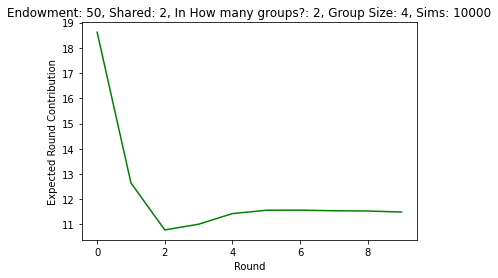

In [149]:
x = [i for i in range(NUM_ROUNDS)]
y = example_MC[1][:-1]
plt.title(f"Endowment: {ENDOWMENT}, Shared: {SHARED}, In How many groups?: {NUM_MEMBERSHIP}, Group Size: {GROUP_SIZE}, Sims: {SIMS}")
plt.xlabel("Round")
plt.ylabel("Expected Round Contribution")
plt.plot(x, y, color ="green")
plt.show()

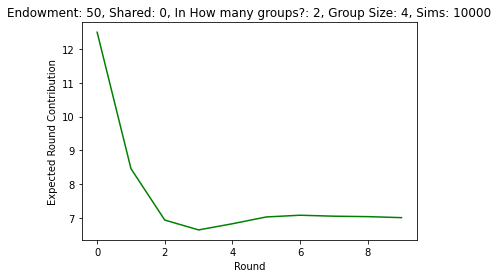

In [181]:
x1 = [i for i in range(NUM_ROUNDS)]
y1 = example_MC_2[1][:-1]
plt.title(f"Endowment: {ENDOWMENT}, Shared: {SHARED}, In How many groups?: {NUM_MEMBERSHIP}, Group Size: {GROUP_SIZE}, Sims: {SIMS}")
plt.xlabel("Round")
plt.ylabel("Expected Round Contribution")
plt.plot(x1, y1, color ="green")
plt.show()

#### Function Archive – No longer using, but did not feel safe enough to delete

In [ ]:
#def initailize_contribtions_with_player_types(NUM_PLAYERS, NUM_MEMBERSHIP, ENDOWMENT, SHARED, player_type_matrix):
   # initial_contributions = np.zeros([NUM_PLAYERS,NUM_MEMBERSHIP]) 
   # if SHARED:
""" for i in range(NUM_PLAYERS):
            initial_contribution_first_group = random.randint(0, ENDOWMENT)
            initial_contributions[i][0] = initial_contribution_first_group
            for j in range(1, NUM_MEMBERSHIP):
                successive_initial_contributions = random.randint(0,ENDOWMENT - initial_contribution_first_group)
                initial_contributions[i][j] = successive_initial_contributions
                initial_contribution_first_group += successive_initial_contributions"""